The further presented attempt to create a macro economic Point-in-Time PD model will be based on the assumption of having Default Rate as a target variable and the usage of Historical Macroeconomic Data as explanatory variables. Both Default Rate and Macroeconomic variables will be discussed.

In [241]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 

from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objects as go

In [242]:
# The Default Rate data import and prep.
data_default_rate = pd.read_excel('CaseStudyData_2023-1.xlsx', sheet_name='Corporate Default Rate')

df = pd.DataFrame(data_default_rate, columns=['Year', 'Global Corporate Default Rate'])
df.columns = ['Year', 'Default_Rate']
df

,Year,Default_Rate
0,2000,2.48
1,2001,3.77
2,2002,3.60
3,2003,1.93
4,2004,0.78
5,2005,0.60
6,2006,0.48
7,2007,0.37
8,2008,1.80
9,2009,4.19


In [243]:
# The Macroeconomic data import and prep.
dfHD = pd.read_excel('CaseStudyData_2023-1.xlsx', sheet_name= 'Historic Data')
Nofirstcol = dfHD.iloc[:, 1:]
Nofirstcol.columns = ['DELETE_Unemployment','Consumer Price Index','Real Gross Domestic Product','EURIBOR - 3-Month', 'Central government bond yield curve ','GDP growth rate','Yield Structure','CPI rate','Unemployment rate',]
Nofirstcol

Nofirstcol = Nofirstcol.loc[:,['Unemployment rate',
                'Consumer Price Index',
                'Real Gross Domestic Product',
                'EURIBOR - 3-Month',
                'Central government bond yield curve ',
                'Yield Structure']]
dfHD

,Description:,"Labor Markets: Unemployment rate, (%, SA)","Consumer Price Index: EU Harmonized - Total, (Index 2015=100, SA)","National Accounts: Real Gross Domestic Product [GDP] - Market exchange rate, (Bil. 2012 USD, CDASAAR)","Interest Rate: EURIBOR - 3-Month, (% p.a., NSA)","Interest Rates: Central government bond yield curve - All bond ratings total - Spot rate - 10 year maturity, (% p.a., NSA)",GDP growth rate,"Yield Structure, long-term - short-term (%)",CPI rate,Unemployment rate
0,2000,9.554567,75.807483,11155.393303,4.391767,5.438877,NaN,1.047110,NaN,0.095546
1,2001,8.743238,77.637991,11402.944194,4.261783,5.027295,0.022191,0.765512,0.024147,0.087432
2,2002,8.965001,79.398093,11512.194638,3.318592,4.922900,0.009581,1.604308,0.022671,0.089650
3,2003,9.363403,81.082631,11596.698815,2.333467,4.160854,0.007340,1.827387,0.021216,0.093634
4,2004,9.408270,82.847143,11834.274098,2.106333,4.140425,0.020486,2.034092,0.021762,0.094083
5,2005,9.363484,84.665718,12046.125375,2.184683,3.443947,0.017902,1.259264,0.021951,0.093635
6,2006,8.653446,86.533181,12449.391838,3.079225,3.811601,0.033477,0.732376,0.022057,0.086534
7,2007,7.713766,88.406260,12822.815358,4.277608,4.281329,0.029995,0.003721,0.021646,0.077138
8,2008,7.747383,91.363413,12863.750637,4.634233,4.369707,0.003192,-0.264527,0.033450,0.077474
9,2009,9.845381,91.653570,12287.567824,1.228358,4.047733,-0.044791,2.819374,0.003176,0.098454


First step in preparing the Default Rate data for modelling is to ensure that predicted DR are always between the 0 and 1 to be applicable for use in a regression. In order to do that, Log Odds formula is used and results are presented in the below Table 16. For purpose of calculation, DR are presented in decimal numbers.

In [244]:
# Creating the logistic odds 
df['Default_Rate'] = df['Default_Rate']/100
def logit(dr):
    return np.log(dr / (1 - dr))
df['Logistic_Odds'] = df.apply(lambda row: logit(row['Default_Rate']), axis=1)
df

,Year,Default_Rate,Logistic_Odds
0,2000,0.0248,-3.671799
1,2001,0.0377,-3.239666
2,2002,0.0360,-3.287572
3,2003,0.0193,-3.928162
4,2004,0.0078,-4.845801
5,2005,0.0060,-5.109978
6,2006,0.0048,-5.334328
7,2007,0.0037,-5.595716
8,2008,0.0180,-3.999220
9,2009,0.0419,-3.129666


Prior to the estimation of an econometric model, a critical preparatory step is the examination of stationarity in Default Rate and macroeconomic variables. Stationarity, a fundamental premise in regression analysis, necessitates the constancy of mean, variance, and autocorrelation over time. Non-adherence to this assumption can lead to erroneous interpretations and misleading conclusions regarding the interrelationships among variables. Ensuring stationarity is pivotal for the integrity and reliability of regression outcomes, as any deviations may result in spurious correlations and diminished predictive precision of the model. A preliminary assessment of stationarity can be conducted visually by analysing the time series graph, where a stationary series is indicated by a consistent mean and variance throughout, absent of any significant long-term trends, and exhibiting stable fluctuations around the mean.

In [245]:
# Plot of the Default Rate 

import plotly.express as px 

fig = px.line(df, y="Default_Rate", #, x="Year"
              title='Default Rate',
              width=600, height=600,
              line_shape='linear')

fig.update_xaxes(showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,)

fig.update_traces(mode='markers+lines')
fig.show()

It is possible to see on the above presented graph that Default Rates seems to be without an obvious trend which would suggest that it is a stationary time series. To make sure, one of the most popular among unit root tests is performed. Statistical test called Augmented Dickey-Fuller (ADF) test is used and the same is performed for the other variables i.e Macroeconomic Variables. This test assesses the H0 hypothesis – time series is non-stationary, where the alternative hypothesis H1 means that time series is stationary. To indicate that, the p-value of the test lower than 5% allow for rejection of null hypothesis.

In [246]:
# Defining a function to perform stationarity test ADF

def stationarity_test(df1, df2, lag):

    dff = pd.DataFrame(columns=['ADF Statistic:', 'p-value:', 'usedlags:','nobs:'])

    def perform_adf_test(series, col):
        result = adfuller(series, maxlag=lag,  autolag=None, regression='ct')
        dff.loc[col, ['ADF Statistic:']] = result[0]
        dff.loc[col, ['p-value:']] = result[1]
        dff.loc[col, ['usedlags:']] = result[2]
        dff.loc[col, ['nobs:']] = result[3]

    for column in df1.columns:
        perform_adf_test(df1[column], column)

    result = adfuller(df2['Default_Rate'], maxlag=lag,  autolag=None, regression='ct')              #maxlag=0, autolag='t-stat',)
    if 'Default_Rate_diff' in df2.columns: 
        result2 = adfuller(df2['Default_Rate_diff'], maxlag=lag,  autolag=None, regression='ct')
        dff.loc['Default_Rate_diff', ['ADF Statistic:']] = result2[0]
        dff.loc['Default_Rate_diff', ['p-value:']] = result2[1]
        dff.loc['Default_Rate_diff', ['usedlags:']] = result2[2]
        dff.loc['Default_Rate_diff', ['nobs:']] = result2[3]
    dff.loc['Default_Rate', ['ADF Statistic:']] = result[0]
    dff.loc['Default_Rate', ['p-value:']] = result[1]
    dff.loc['Default_Rate', ['usedlags:']] = result[2]
    dff.loc['Default_Rate', ['nobs:']] = result[3]

    return dff

df0lag = stationarity_test(Nofirstcol, df, 0)
df1lag = stationarity_test(Nofirstcol, df, 1)
df2lag = stationarity_test(Nofirstcol, df, 2)

In [247]:
stationarity_test(Nofirstcol.dropna(),df.dropna(),1)

,ADF Statistic:,p-value:,usedlags:,nobs:
Unemployment rate,-1.205772,0.909313,1,21
Consumer Price Index,-2.120793,0.534435,1,21
Real Gross Domestic Product,-3.004985,0.130693,1,21
EURIBOR - 3-Month,-3.005445,0.130565,1,21
Central government bond yield curve,-1.967249,0.619155,1,21
Yield Structure,-2.751716,0.215243,1,21
Default_Rate,-3.732317,0.020315,1,21


As expected, the test results presented in the above table allow for rejection of null hypothesis for the Default Rate, however null hypothesis is confirmed for the rest of variables tested. In order to make macroeconomic variables stationary which is needed for further model, a simple differencing method is used. By looking at the data and even on the Figure 2 it can be seen that unfortunately a negative values occur for example for EURIBOR – 3-month which wont allow to perform log differencing.

To maintain consistency, simple differencing with the below presented formula is performed. (Please see pdf report)
Application of this differencing formula should make variables stationary. To confirm that the ADF test was performed again and the results are presented on the below Table

In [248]:
# Differencing to make variables stationary

for column in Nofirstcol.columns:
    Nofirstcol[f'{column}_diff'] = Nofirstcol[column].diff()

df['Default_Rate_diff'] = df['Default_Rate'].diff()

# Dropna to exclude first row that contains nan values due to differencing
Nofirstcol.dropna()
df.dropna()

,Year,Default_Rate,Logistic_Odds,Default_Rate_diff
1,2001,0.0377,-3.239666,0.0129
2,2002,0.0360,-3.287572,-0.0017
3,2003,0.0193,-3.928162,-0.0167
4,2004,0.0078,-4.845801,-0.0115
5,2005,0.0060,-5.109978,-0.0018
6,2006,0.0048,-5.334328,-0.0012
7,2007,0.0037,-5.595716,-0.0011
8,2008,0.0180,-3.999220,0.0143
9,2009,0.0419,-3.129666,0.0239
10,2010,0.0121,-4.402376,-0.0298


In [249]:
stationarity_test(Nofirstcol.dropna(),df.dropna(),1)

,ADF Statistic:,p-value:,usedlags:,nobs:
Unemployment rate,-1.170983,0.916281,1,20
Consumer Price Index,-2.025984,0.587211,1,20
Real Gross Domestic Product,-2.998865,0.132399,1,20
EURIBOR - 3-Month,-2.862584,0.174908,1,20
Central government bond yield curve,-1.8741,0.667982,1,20
Yield Structure,-2.55375,0.30163,1,20
Unemployment rate_diff,-3.023537,0.125619,1,20
Consumer Price Index_diff,-1.072176,0.933585,1,20
Real Gross Domestic Product_diff,-4.047442,0.007521,1,20
EURIBOR - 3-Month_diff,-4.093784,0.00644,1,20


In [250]:
# Example of a plot of the macroeconomic variable and also applicable for differenced variables 
fig = px.line(Nofirstcol, y='Yield Structure',
              title='Yield Structure',
              width=600, height=600,
              line_shape='linear')


fig.update_xaxes(showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,)


fig.update_traces(mode='markers+lines')
fig.show()

Estimation of the Default rate was performed using three differenced macroeconomic variables i.e. Real Gross Domestic Product_diff, EURIBOR – 3-month_diff and Yield Structure_diff as the explanatory variables. The below tables present the regression results.

In [251]:
Explanatory = Nofirstcol.loc[:, ['Real Gross Domestic Product_diff',
                                  'EURIBOR - 3-Month_diff', 
                                  'Yield Structure_diff']].dropna()
dependent = df.iloc[1:]['Logistic_Odds']

# print(Explanatory) 
# print(dependent)

Explanatory_train_sm = sm.add_constant(Explanatory) 
LRmodel2 = sm.OLS(dependent, Explanatory_train_sm).fit()
print(LRmodel2.summary())

residuals =LRmodel2.resid

DRpredictions = LRmodel2.predict(Explanatory_train_sm)

                            OLS Regression Results                            
Dep. Variable:          Logistic_Odds   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     5.998
Date:                Thu, 15 Feb 2024   Prob (F-statistic):            0.00511
Time:                        15:54:56   Log-Likelihood:                -14.141
No. Observations:                  22   AIC:                             36.28
Df Residuals:                      18   BIC:                             40.65
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

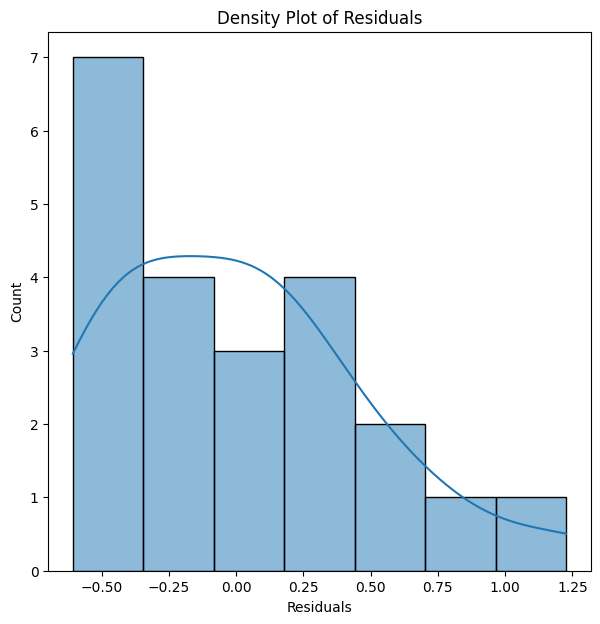

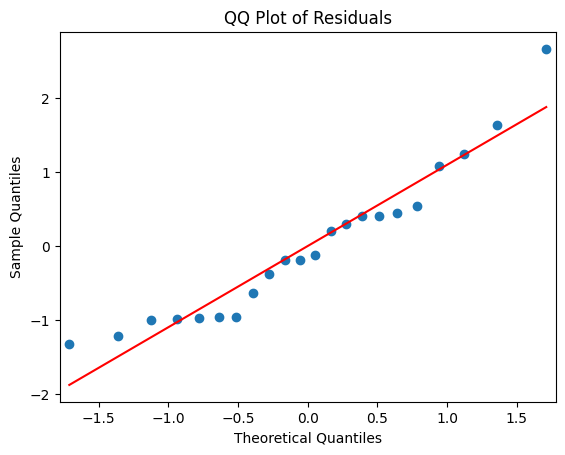

In [252]:
# Density Plot of Residuals
plt.figure(figsize=(7, 7))
sns.histplot(residuals, kde=True, bins=7)

plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.grid(False)
plt.show()

# QQ plot
sm.qqplot(residuals, line ='r', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

The QQ plot above presents, that the dataset follows a theoretical normal distribution as points on the graph seems to be not far from the line so this may suggest that residuals are normally distributed. The Figure 8 on the left shows the estimated values together with the historical provided data of Default Rates which were taken as dependent variable. By looking at the graph, estimated model fits good the data with minor exceptions. This model is simplified as possible which allows this well fitting of data and easiness of interpretation.

In [253]:
# Create traces
trace1 = go.Scatter(
    x=list(range(len(df.iloc[1:,:]['Logistic_Odds']))), # Assuming sequential x values, modify as needed
    y=df['Logistic_Odds'],
    mode='lines',
    name='Actual Values'
)

trace2 = go.Scatter(
    x=list(range(1,len(DRpredictions))),       
    y=DRpredictions,
    mode='lines',
    name='Predicted Values'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='Actual vs Predicted Values',
    xaxis_title='Index',
    yaxis_title='Values',
    width=1000, height=1000,)

# Show the plot
fig.show()

Following the application of the econometric model, the subsequent task is to estimate Default Rates for the ensuing three-year prediction period (2023, 2024, 2024). These estimations are outlined in table 20, reflecting values under three projected scenarios: optimistic, baseline, and pessimistic. The differing Default Rate predictions for each scenario arise from the unique behaviour of the macroeconomic variables in the model. An integral step in calculating Point-in-Time PDs is the derivation of Shift Factors, which is done using the formula provided below: (please see pdf report)

In [254]:
DRpredictions

1    -4.465596
2    -4.037609
3    -4.063669
4    -4.387594
5    -4.552774
6    -4.893710
7    -4.988782
8    -4.498949
9    -2.689650
10   -4.345484
11   -4.648844
12   -4.012186
13   -4.243066
14   -4.516662
15   -4.468105
16   -4.416466
17   -4.493883
18   -4.480088
19   -4.517618
20   -3.816616
21   -4.683387
22   -4.820789
dtype: float64

In [255]:
# Importing the data for scenarios 
# 'Real Gross Domestic Product_diff',
# 'EURIBOR - 3-Month_diff', 
# 'Yield Structure_diff'

data_fdb = pd.read_excel('CaseStudyData_2023-1.xlsx', 
                         sheet_name='Forecast Data (Baseline)').iloc[:, [3,4,7]]
data_fdp = pd.read_excel('CaseStudyData_2023-1.xlsx', 
                         sheet_name='Forecast Data (Pessimistic)').iloc[:, [3,4,7]]
data_fdo = pd.read_excel('CaseStudyData_2023-1.xlsx', 
                         sheet_name='Forecast Data (Optimistic)').iloc[:, [3,4,7]]

data_fdb.columns = ['Real Gross Domestic Product', 'EURIBOR - 3-Month', 'Yield Structure']
data_fdp.columns = ['Real Gross Domestic Product', 'EURIBOR - 3-Month', 'Yield Structure']
data_fdo.columns = ['Real Gross Domestic Product', 'EURIBOR - 3-Month', 'Yield Structure']

In [256]:
# The Macroeconomic data import and prep.
dfHD = pd.read_excel('CaseStudyData_2023-1.xlsx', sheet_name= 'Historic Data').iloc[:, [3,4,7]]

dfHD.columns = ['Real Gross Domestic Product', 'EURIBOR - 3-Month', 'Yield Structure']

In [257]:
def calculate_diff(df1):
    df1 = pd.concat([dfHD, df1]).reset_index(drop=True)
    for column in df1.columns: 
        df1[f'{column}_diff'] = df1[column].diff()

    return df1

In [258]:
data_fdb = calculate_diff(data_fdb)
data_fdp = calculate_diff(data_fdp)
data_fdo = calculate_diff(data_fdo)

In [259]:
def log_odds_to_probability(log_odds):
    return 1 / (1 + np.exp(-log_odds))

In [260]:
# Predicting the scenarios step by step without loop to maintain better controll 

# Base 
predictBasic = data_fdb.loc[:, ['Real Gross Domestic Product_diff',
                                  'EURIBOR - 3-Month_diff', 
                                  'Yield Structure_diff']].dropna()

PredictSample = sm.add_constant(predictBasic) 

DRpredictionsBasic = LRmodel2.predict(PredictSample)

probabilitiesBasic = log_odds_to_probability(np.array(list(DRpredictionsBasic)))
probabilitiesBasic

array([0.01136715, 0.01733384, 0.01689548, 0.01227798, 0.01042804,
       0.00743784, 0.00676784, 0.01099837, 0.06358686, 0.01279929,
       0.0094819 , 0.01777223, 0.0141601 , 0.01080736, 0.01133898,
       0.01193273, 0.01105362, 0.01120543, 0.01079714, 0.02152846,
       0.00916291, 0.00799597, 0.00482928, 0.01196237, 0.01225816])

In [261]:
# Pessimistic 
predictPessimistic = data_fdp.loc[:, ['Real Gross Domestic Product_diff',
                                  'EURIBOR - 3-Month_diff', 
                                  'Yield Structure_diff']].dropna()

PredictSample = sm.add_constant(predictPessimistic) 

DRpredictionsPessimistic = LRmodel2.predict(PredictSample)

probabilitiesPessimistic = log_odds_to_probability(np.array(list(DRpredictionsPessimistic)))
probabilitiesPessimistic

array([0.01136715, 0.01733384, 0.01689548, 0.01227798, 0.01042804,
       0.00743784, 0.00676784, 0.01099837, 0.06358686, 0.01279929,
       0.0094819 , 0.01777223, 0.0141601 , 0.01080736, 0.01133898,
       0.01193273, 0.01105362, 0.01120543, 0.01079714, 0.02152846,
       0.00916291, 0.00799597, 0.00461525, 0.02033703, 0.01316011])

In [262]:
# Optimistic 
predictOptimistic = data_fdo.loc[:, ['Real Gross Domestic Product_diff',
                                  'EURIBOR - 3-Month_diff', 
                                  'Yield Structure_diff']].dropna()

PredictSample = sm.add_constant(predictOptimistic) 

DRpredictionsOptimistic = LRmodel2.predict(PredictSample)

probabilitiesOptimistic = log_odds_to_probability(np.array(list(DRpredictionsOptimistic)))
probabilitiesOptimistic

array([0.01136715, 0.01733384, 0.01689548, 0.01227798, 0.01042804,
       0.00743784, 0.00676784, 0.01099837, 0.06358686, 0.01279929,
       0.0094819 , 0.01777223, 0.0141601 , 0.01080736, 0.01133898,
       0.01193273, 0.01105362, 0.01120543, 0.01079714, 0.02152846,
       0.00916291, 0.00799597, 0.00642488, 0.0063531 , 0.01109508])

In [263]:
# Creating the DataFrame with the results for each year and scenario 
DataTs = pd.DataFrame(columns = ['Scenario','Year', 'Estimated DR'])
xx = 0
for x,y in zip([probabilitiesOptimistic, probabilitiesPesimistic, probabilitiesBasic],
                ['Optimistic', 'Pesimistic', 'Base']):
    for i in [3,2,1]:
        DataTs = pd.concat([DataTs, pd.DataFrame({'Scenario':y,
                                                   'Year':2026-i,
                                                     'Estimated DR':x[-i]},
                                                       index=[xx])])
        xx +=1

# Incorporating the Average DR (2000-2022) and calculating the Shift Factor 
DataTs['AVG'] = 0.159
DataTs['Shift factor'] = DataTs['Estimated DR'] / DataTs['AVG']
DataTs

C:\Users\mateu\AppData\Local\Temp\ipykernel_11804\1513731611.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Scenario,Year,Estimated DR,AVG,Shift factor
0,Optimistic,2023,0.006425,0.159,0.040408
1,Optimistic,2024,0.006353,0.159,0.039957
2,Optimistic,2025,0.011095,0.159,0.069780
3,Pesimistic,2023,0.004615,0.159,0.029027
4,Pesimistic,2024,0.020337,0.159,0.127906
5,Pesimistic,2025,0.013160,0.159,0.082768
6,Base,2023,0.004829,0.159,0.030373
7,Base,2024,0.011962,0.159,0.075235
8,Base,2025,0.012258,0.159,0.077095


It can be seen that Base scenario presents higher estimations of Default Rate than the Optimistic Scenario. Also the Pessimistic Scenario estimates higher PD than in Optimistic Scenario only for the year 2024. Value of Shift Factor for that year is also relatively much higher (1.28) than for other years and scenarios. It tends to be a common problem when estimating PiT PD model that results are not intuitive as explained above i.e. Base Scenario higher estimates than optimistic.
Applying the above-calculated shift factors, the formula for adjusting the Conditional Through-the-Cycle PDs (Table 15.) is as follows: (please see pdf report)

In [264]:
# Reading the Data Frames from csv files that were created in TTC-PD
# model as this is going to be used for PIT-PD

conditional = pd.read_csv('cond.csv').set_index('Unnamed: 0')

conditional = conditional.reindex(['1-year Default',
                                   '2-year Default',
                                   '3-year Default',
                                   '4-year Default',
                                   '5-year Default',
                                   '6-year Default',
                                   '7-year Default',
                                   '8-year Default',
                                   '9-year Default',
                                   '10-year Default'])
conditional

,AAA,AA,A,BBB,BB,B,CCC
Unnamed: 0,,,,,,,
1-year Default,0.031100,0.038800,0.042600,0.059700,0.100800,0.156400,0.408500
2-year Default,0.032201,0.039347,0.043714,0.061336,0.104516,0.167528,0.346252
3-year Default,0.033145,0.039902,0.044803,0.062783,0.107411,0.170788,0.288533
4-year Default,0.033996,0.040474,0.045859,0.064070,0.109412,0.170199,0.243123
5-year Default,0.034787,0.041066,0.046876,0.065203,0.110592,0.167673,0.211290
6-year Default,0.035537,0.041675,0.047850,0.066188,0.111070,0.164171,0.190176
7-year Default,0.036256,0.042297,0.048781,0.067027,0.110967,0.160194,0.176136
8-year Default,0.036952,0.042930,0.049665,0.067728,0.110389,0.156006,0.166328
9-year Default,0.037629,0.043568,0.050503,0.068300,0.109432,0.151743,0.158927


In [265]:
cumulative = pd.read_csv('cum.csv').set_index('Unnamed: 0')
cumulative

,AAA,AA,A,BBB,BB,B,CCC
Unnamed: 0,,,,,,,
1-year Default,0.031100,0.038800,0.042600,0.059700,0.100800,0.156400,0.408500
2-year Default,0.062300,0.076620,0.084451,0.117374,0.194780,0.297726,0.613308
3-year Default,0.093380,0.113465,0.125471,0.172788,0.281270,0.417666,0.724882
4-year Default,0.124201,0.149347,0.165576,0.225787,0.359907,0.516779,0.791769
5-year Default,0.154667,0.184280,0.204690,0.276268,0.430696,0.597802,0.835766
6-year Default,0.184707,0.218275,0.242746,0.324170,0.493929,0.663831,0.867000
7-year Default,0.214266,0.251339,0.279685,0.369469,0.550086,0.717683,0.890426
8-year Default,0.243300,0.283479,0.315459,0.412174,0.599752,0.761726,0.908651
9-year Default,0.271774,0.314697,0.350030,0.452322,0.643552,0.797883,0.923169


In [266]:
Optimistic = pd.DataFrame(index=conditional.columns)
for year, x in zip(conditional.index[:3], [2023,2024,2025]):
    f = conditional.loc[year] * float(DataTs[(DataTs['Scenario'] == 'Optimistic')& (DataTs['Year'] == x)]['Shift factor'].values)
    Optimistic = pd.concat([Optimistic, pd.DataFrame(f).T]).dropna()

Pesimistic = pd.DataFrame(index=conditional.columns)
for year, x in zip(conditional.index[:3], [2023,2024,2025]):
    f = conditional.loc[year] * float(DataTs[(DataTs['Scenario'] == 'Pesimistic')& (DataTs['Year'] == x)]['Shift factor'].values)
    Pesimistic = pd.concat([Pesimistic, pd.DataFrame(f).T]).dropna()

Base = pd.DataFrame(index=conditional.columns)
for year, x in zip(conditional.index[:3], [2023,2024,2025]):
    f = conditional.loc[year] * float(DataTs[(DataTs['Scenario'] == 'Base')& (DataTs['Year'] == x)]['Shift factor'].values)
    Base = pd.concat([Base, pd.DataFrame(f).T]).dropna()
    # print(Base)

Base_final = conditional.copy()
Base_final.loc[Base_final.index[:3]] =Base 
Base_final.index = Base_final.index.rename("years")
Base_final.iloc[:3] = Base_final.iloc[:3] *10

Optimistic_final = conditional.copy()
Optimistic_final.loc[Optimistic_final.index[:3]] =Optimistic 
Optimistic_final.index = Optimistic_final.index.rename("years")
Optimistic_final.iloc[:3] = Optimistic_final.iloc[:3] *10

Pesimistic_final = conditional.copy()
Pesimistic_final.loc[Pesimistic_final.index[:3]] =Pesimistic 
Pesimistic_final.index = Pesimistic_final.index.rename("years")
Pesimistic_final.iloc[:3] = Pesimistic_final.iloc[:3] *10

C:\Users\mateu\AppData\Local\Temp\ipykernel_11804\2028815988.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\mateu\AppData\Local\Temp\ipykernel_11804\2028815988.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\mateu\AppData\Local\Temp\ipykernel_11804\2028815988.py:3: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\mateu\AppData\Local\Temp\ipykernel_11804\2028815988.py:8: DeprecationWarning:

Conversion of an array with ndim > 0 to a 

In Table 21 below, the Conditional Point-in-Time-PDs are enumerated. To enable a comprehensive comparison with the Conditional TTC-PDs, both are estimated for a period of ten years. Nevertheless, given that shift factors were determined exclusively for the initial trio of years, the PDs for the remaining seven-year period (2026-2032) are identical to those in the TTC model for each assessed scenario.

In [267]:
Base_final.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
years,,,,,,,
1-year Default,0.94%,1.18%,1.29%,1.81%,3.06%,4.75%,12.41%
2-year Default,2.42%,2.96%,3.29%,4.61%,7.86%,12.60%,26.05%
3-year Default,2.56%,3.08%,3.45%,4.84%,8.28%,13.17%,22.24%
4-year Default,3.40%,4.05%,4.59%,6.41%,10.94%,17.02%,24.31%
5-year Default,3.48%,4.11%,4.69%,6.52%,11.06%,16.77%,21.13%
6-year Default,3.55%,4.17%,4.79%,6.62%,11.11%,16.42%,19.02%
7-year Default,3.63%,4.23%,4.88%,6.70%,11.10%,16.02%,17.61%
8-year Default,3.70%,4.29%,4.97%,6.77%,11.04%,15.60%,16.63%
9-year Default,3.76%,4.36%,5.05%,6.83%,10.94%,15.17%,15.89%


In [268]:
Pesimistic_final.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
years,,,,,,,
1-year Default,0.90%,1.13%,1.24%,1.73%,2.93%,4.54%,11.86%
2-year Default,4.12%,5.03%,5.59%,7.85%,13.37%,21.43%,44.29%
3-year Default,2.74%,3.30%,3.71%,5.20%,8.89%,14.14%,23.88%
4-year Default,3.40%,4.05%,4.59%,6.41%,10.94%,17.02%,24.31%
5-year Default,3.48%,4.11%,4.69%,6.52%,11.06%,16.77%,21.13%
6-year Default,3.55%,4.17%,4.79%,6.62%,11.11%,16.42%,19.02%
7-year Default,3.63%,4.23%,4.88%,6.70%,11.10%,16.02%,17.61%
8-year Default,3.70%,4.29%,4.97%,6.77%,11.04%,15.60%,16.63%
9-year Default,3.76%,4.36%,5.05%,6.83%,10.94%,15.17%,15.89%


In [269]:
Optimistic_final.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
years,,,,,,,
1-year Default,1.26%,1.57%,1.72%,2.41%,4.07%,6.32%,16.51%
2-year Default,1.29%,1.57%,1.75%,2.45%,4.18%,6.69%,13.84%
3-year Default,2.31%,2.78%,3.13%,4.38%,7.50%,11.92%,20.13%
4-year Default,3.40%,4.05%,4.59%,6.41%,10.94%,17.02%,24.31%
5-year Default,3.48%,4.11%,4.69%,6.52%,11.06%,16.77%,21.13%
6-year Default,3.55%,4.17%,4.79%,6.62%,11.11%,16.42%,19.02%
7-year Default,3.63%,4.23%,4.88%,6.70%,11.10%,16.02%,17.61%
8-year Default,3.70%,4.29%,4.97%,6.77%,11.04%,15.60%,16.63%
9-year Default,3.76%,4.36%,5.05%,6.83%,10.94%,15.17%,15.89%


By looking at the values presented in above tables in can be observed that PiT PDs are lower in first 3 years than in TTC PDs, all else for each scenario is the same. This can be seen on the below presented figures.
This values can be used to compute the Cumulative multi-year Point-in-Time PD (Table 22 below the graphs) by the use of the following formula: (see pdf report)

In [270]:
import plotly.express as px 

fig = px.line(Optimistic_final)
fig.update_layout(title='Optimistic scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

In [271]:
fig = px.line(Pesimistic_final)
fig.update_layout(title='Pesymistic scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

In [272]:
fig = px.line(Base_final)
fig.update_layout(title='Base Scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

In [273]:
def funcc(val):
    val = list(val)
    listaa = [val[0]]
    vall = val[1:]
    for i in range(1,len(val)):
        yy = val[i-1]
        cc = listaa[i-1]
        listaa.append(yy * float(1-cc) + cc)

    return pd.Series(listaa)

   
Pesimistic_final_cumulative = Pesimistic_final.apply(lambda row: funcc(row))
Optimistic_final_cumulative = Optimistic_final.apply(lambda row: funcc(row))
Base_final_cumulative = Base_final.apply(lambda row: funcc(row))

In [274]:
Optimistic_final_cumulative.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
0,1.26%,1.57%,1.72%,2.41%,4.07%,6.32%,16.51%
1,2.50%,3.11%,3.41%,4.77%,7.98%,12.24%,30.29%
2,3.75%,4.63%,5.10%,7.10%,11.82%,18.11%,39.93%
3,5.98%,7.29%,8.07%,11.17%,18.43%,27.87%,52.03%
4,9.17%,11.04%,12.28%,16.86%,27.36%,40.15%,63.69%
5,12.33%,14.70%,16.39%,22.28%,35.39%,50.18%,71.36%
6,15.45%,18.25%,20.40%,27.43%,42.57%,58.36%,76.81%
7,18.51%,21.71%,24.28%,32.29%,48.94%,65.03%,80.89%
8,21.53%,25.07%,28.04%,36.88%,54.58%,70.49%,84.07%
9,24.48%,28.33%,31.67%,41.19%,59.55%,74.97%,86.60%


In [275]:
Pesimistic_final_cumulative.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
0,0.90%,1.13%,1.24%,1.73%,2.93%,4.54%,11.86%
1,1.80%,2.24%,2.46%,3.44%,5.77%,8.87%,22.31%
2,5.84%,7.16%,7.91%,11.01%,18.36%,28.40%,56.72%
3,8.43%,10.23%,11.33%,15.64%,25.62%,38.52%,67.05%
4,11.54%,13.86%,15.39%,21.04%,33.76%,48.98%,75.06%
5,14.62%,17.40%,19.36%,26.19%,41.08%,57.54%,80.33%
6,17.65%,20.84%,23.22%,31.07%,47.63%,64.51%,84.07%
7,20.64%,24.19%,26.96%,35.69%,53.44%,70.19%,86.88%
8,23.57%,27.44%,30.59%,40.05%,58.58%,74.84%,89.06%
9,26.44%,30.60%,34.10%,44.14%,63.11%,78.66%,90.80%


In [276]:
Base_final_cumulative.style.set_properties(**{'background-color': 'blue',
                           'color': 'white'}).format("{:.2%}")

,AAA,AA,A,BBB,BB,B,CCC
0,0.94%,1.18%,1.29%,1.81%,3.06%,4.75%,12.41%
1,1.88%,2.34%,2.57%,3.59%,6.03%,9.27%,23.28%
2,4.26%,5.23%,5.78%,8.04%,13.42%,20.71%,43.26%
3,6.70%,8.15%,9.03%,12.49%,20.59%,31.15%,55.88%
4,9.88%,11.87%,13.20%,18.10%,29.28%,42.87%,66.61%
5,13.01%,15.49%,17.27%,23.44%,37.10%,52.45%,73.66%
6,16.10%,19.01%,21.23%,28.51%,44.08%,60.25%,78.67%
7,19.14%,22.43%,25.07%,33.30%,50.29%,66.62%,82.43%
8,22.13%,25.76%,28.79%,37.82%,55.78%,71.83%,85.35%
9,25.06%,29.00%,32.39%,42.06%,60.62%,76.10%,87.68%


Figures (below) 12, 13 and 14 present an a plot of the cumulative multi-year Point-in-Time Probability of Defaults (PIT PDs) across the three delineated scenarios. A detailed examination reveals that the curves corresponding to each rating class are distinctly non-overlapping, indicating clear demarcation in risk assessments. Moreover, in the initial three-year span, these curves exhibit different shapes, a variation attributable to the application of scenario-specific shift factors.

In [277]:
fig = px.line(Optimistic_final_cumulative)
fig.update_layout(title='Optimistic Cumulative Scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

In [278]:
fig = px.line(Pesimistic_final_cumulative)
fig.update_layout(title='Pesimistic cumulative Scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

In [279]:
fig = px.line(Base_final_cumulative)
fig.update_layout(title='Base Cumulative Scenario', autosize=False,
                    width=600, height=600,
                    margin=dict(l=65, r=50, b=65, t=90),
                    xaxis_title="Years",
                    yaxis_title="Cummulative multi-year Probability of Default")

fig.update_traces(mode='markers+lines')
fig.show()

Conversely, Figures 15, 16 and 17 provide an intricate comparison of the cumulative PIT versus Through-the-Cycle Probability of Defaults (TTC PDs) for the highest credit rating category, AAA, under all three scenarios: optimistic, baseline, and pessimistic. A meticulous analysis of these figures shows that, irrespective of the scenario, the PIT PDs consistently register at lower values compared to their TTC counterparts. This disparity underscores the intrinsic differences in the probabilistic modelling approaches between PIT and TTC PDs under varying economic conditions. For further reference, below are also figures comparing the Conditional PiT PD with TTC PD.

In [280]:
# Create traces
trace1 = go.Scatter(
    x=list(range(10)),
    y=cumulative['AAA'],
    mode='lines+markers',
    name='Cumulative TTC'
)

trace2 = go.Scatter(
    x=list(range(10)),                       
    y=Pesimistic_final_cumulative['AAA'],
    mode='lines+markers',
    name='PIT pesimistic'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='TTC vs Pesimistic',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

In [281]:
trace1 = go.Scatter(
    x=list(range(10)), 
    y=cumulative['AAA'],
    mode='lines+markers',
    name='Cumulative TTC'
)

trace2 = go.Scatter(
    x=list(range(10)),
    y=Pesimistic_final['AAA'],
    mode='lines+markers',
    name='PIT optimistic'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='TTC vs Optimistic',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

In [282]:
trace1 = go.Scatter(
    x=list(range(10)), 
    y=cumulative['AAA'],
    mode='lines+markers',
    name='Cumulative TTC'
)

trace2 = go.Scatter(
    x=list(range(10)),
    y=Base_final_cumulative['AAA'],
    mode='lines+markers',
    name='PIT Base'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='TTC vs Base',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

In [283]:
trace1 = go.Scatter(
    x=list(range(10)), 
    y=conditional['AAA'],
    mode='lines+markers',
    name='Conditional TTC AAA'
)

trace2 = go.Scatter(
    x=list(range(10)),
    y=Pesimistic_final['AAA'],
    mode='lines+markers',
    name='PiT Pesimistic AAA'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='PiT vs Pessimistic AAA',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

In [284]:
trace1 = go.Scatter(
    x=list(range(10)), 
    y=conditional['AAA'],
    mode='lines+markers',
    name='Conditional TTC AAA'
)

trace2 = go.Scatter(
    x=list(range(10)),
    y=Optimistic_final['AAA'],
    mode='lines+markers',
    name='PiT Conditional Optimistic AAA'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='TTC vs AAA Optimistic',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

In [285]:
trace1 = go.Scatter(
    x=list(range(10)),
    y=conditional['AAA'],
    mode='lines+markers',
    name='Conditional TTC AAA'
)

trace2 = go.Scatter(
    x=list(range(10)),
    y=Base_final['AAA'],
    mode='lines+markers',
    name='PiT Conditional AAA Base'
)

# Create the figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Add titles and labels
fig.update_layout(title='TTC vs Base',
    xaxis_title='Index',
    yaxis_title='Values',
    width=800, height=800,)

# Show the plot
fig.show()

Thank you if you made it this far. I'm glad you're interested in my work. 
Please feel free to contact me anywhere; Git, Linkedin, email or directly by phone. 

MK.